# Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import seaborn as sns 
from statsmodels.tsa.stattools import adfuller
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from keras.utils import set_random_seed
from scipy.stats import shapiro

plt.rcParams["figure.figsize"] = (15,5)

2022-12-11 19:21:07.989724: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 19:21:09.341511: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-11 19:21:09.341620: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-11 19:21:14.220665: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

# Variables globales

In [2]:
DATA_PATH = 'Eolica.csv'

# Funciones

In [3]:
def plot_acf_pacf_functions(df: pd.Series, lags=360):
    
    '''Funcion para hacer un grafico de la funcion de autocorrelacion (ACF) y autoco'''
    # Import Data
    # df = pd.read_csv('AirPassengers.csv')
    # Draw Plot
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
    plot_acf(df.fillna(method='ffill').tolist(), ax=ax1, lags=lags)
    plot_pacf(df.fillna(method='ffill').tolist(), ax=ax2, lags=lags)

    # Decorate
    # lighten the borders
    ax1.spines["top"].set_alpha(.3); ax2.spines["top"].set_alpha(.3)
    ax1.spines["bottom"].set_alpha(.3); ax2.spines["bottom"].set_alpha(.3)
    ax1.spines["right"].set_alpha(.3); ax2.spines["right"].set_alpha(.3)
    ax1.spines["left"].set_alpha(.3); ax2.spines["left"].set_alpha(.3)
    
    # font size of tick labels
    ax1.tick_params(axis='both', labelsize=12)
    ax2.tick_params(axis='both', labelsize=12)
    ax1.set_title('ACF')
    ax2.set_title('PACF')

    plt.show()
    
    
def ts_model_diagnostic(y_pred, y_true):
    
    ''' Función para comprobar varias propiedades deseables al definir un modelo de regresión sobre un problema
    de series temporales. Se hacen varias operaciones:
    
    1. Histograma de residuos. Calculo de la media y desviación típica. Test de normalidad de saphiro.
    2. Gráfico temporal de los residuos. Calculo del estadístico Dickey-Fuller aumentado para determinar si los residuos son estacionarios.
    3. Grafico del ajuste. Calculo del MSE
    '''
    residuals = y_true - y_pred
    residuals_mean, residuals_std = np.mean(residuals), np.std(residuals)
    mse = mean_squared_error(y_pred, y_true)
    fuller_pvalue = adfuller(residuals)[1]
    saphiro_pvalue = shapiro(residuals)[1]
    
    # declaracion de graficos
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(16,10), dpi= 80)
    
    # histograma de los redisuos
    ax1.hist(residuals)
    ax1.set_title('Histograma de los residuos')
    
    # serie de los residuos
    ax2.plot(residuals)
    ax2.set_title('Serie de los residuos')
    ax2.axhline(0, color='red')
    
    plt.plot()
    
    ax3.plot(y_pred)
    ax3.plot(y_true)
    ax3.legend(['pred', 'true'])
    ax3.set_title('Ajuste del modelo')

    
    # Definicion de las cajas de texto en cada uno de los graficos
    textstr_residuals = '\n'.join((
    r'$\mu=%.2f$' % (residuals_mean, ),
    r'$p-value=%.2f$' % (fuller_pvalue, )))

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax2.text(0.05, 0.95, textstr_residuals, transform=ax2.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    textstr_histogram = '\n'.join((
    r'$\mu=%.2f$' % (residuals_mean, ),
    r'$p-value=%.2f$' % (saphiro_pvalue, ),
    r'$\sigma=%.2f$' % (residuals_std, )))

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax1.text(0.05, 0.95, textstr_histogram, transform=ax1.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Definicion de las cajas de texto en cada uno de los graficos
    textstr_fit = '\n'.join((
    r'$MSE=%.2f$' % (mse, ),
    r'$periods=%.2f$' % (len(y_pred), )))

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax3.text(0.05, 0.95, textstr_fit, transform=ax3.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    plt.show()
    
    print(f'MSE: {mse}')
    
    return mse

def split_series(series, n_past, n_future):
  
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

# 1. Carga de datos

Se carga el fichero proporcionado.

In [4]:
data = pd.read_csv(DATA_PATH, header=0, parse_dates=[0], index_col=[0], dayfirst=True)
data = data.asfreq('D') # frecuencia del datetimeIndex de pandas
data.head()

,WindSpeed,WindDirection,WindEnergy
Date,,,
2016-01-01,12.96,190.0,280606.59
2016-01-02,10.68,217.0,181981.12
2016-01-03,16.69,223.0,329470.87
2016-01-04,11.35,250.0,216707.38
2016-01-05,12.72,261.0,204859.99


Se ven tres series temporales con granularidad diaria.

# 2. Procesado

En esta sección se revisa si existen valores perdidos, y en su caso rellenan. Tambien se escala la energía (WindEnergy) para tener la variable como porcentaje de la potencia instalada.

## 2.1 Valores nulos

In [5]:
data.isnull().sum()

WindSpeed        6
WindDirection    6
WindEnergy       8
dtype: int64

Se observan valores perdidos en las tres variables, se rellenan mediante interpolación lineal entre los puntos anterior y posterior al valor faltante. 

In [6]:
data = data.interpolate(method='linear')
data.isnull().sum()

WindSpeed        0
WindDirection    0
WindEnergy       0
dtype: int64

Los valores nulos han desaparecido y se puede operar con las librerias usuales sin errores.

## 2.2 Transformación de la potencia

Se transofrma la potencia (WindEnergy en Kw/dia, denotada como $X$) en una variable que mida la potencia producida respecto a la potencia instalada (17560 K h). Se sabe que la variable viene dada en Kw día, por lo que la transofmración es:

$$Z = X \frac{\textrm{Kw}}{\textrm{dia}} \frac{1 \textrm{ dia}}{24 \textrm{ horas}} \frac{1 \textrm{ hora}}{17560 \textrm{ Kw}} = X \frac{1}{421920}$$

Por tanto, para transformarlo de la manera indicada, se divide la variable WindEnergy entre 421920.

In [7]:
data['WindEnergy_percentage'] = data.WindEnergy / 421920

In [8]:
data.head()

,WindSpeed,WindDirection,WindEnergy,WindEnergy_percentage
Date,,,,
2016-01-01,12.96,190.0,280606.59,0.665071
2016-01-02,10.68,217.0,181981.12,0.431317
2016-01-03,16.69,223.0,329470.87,0.780885
2016-01-04,11.35,250.0,216707.38,0.513622
2016-01-05,12.72,261.0,204859.99,0.485542


# 3. Análisis exploratorio

## 3.1 Inspección visual de la serie

Se hace un gráfico de la potencia relativa para ver su comportamiento.

<AxesSubplot: xlabel='Date'>

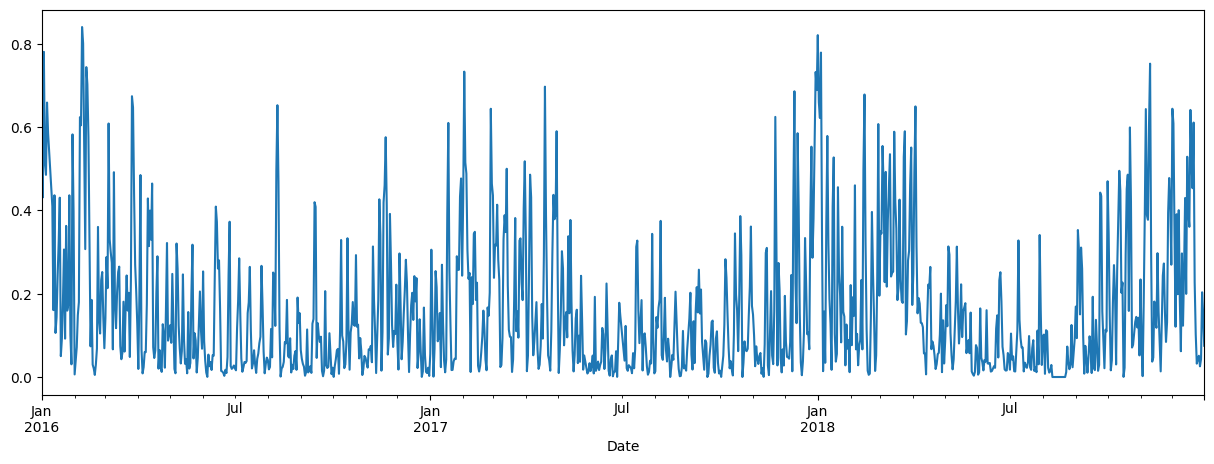

In [9]:
data.WindEnergy_percentage.plot()

Se aprecian varios puntos:

1. Estacionalidad anual débil, con picos a principios de año (Enero, Febrero) y valles en los meses de verano (Junio, Julio).
2. No es estacionaria ya que el nivel de la serie depende de la epoca del año 

Para comprobar la estacionariedad y estacionalidad se hace un boxplot de la potencia relativa segmentado las observaciones por mes de observación.

<AxesSubplot: xlabel='month', ylabel='WindEnergy_percentage'>

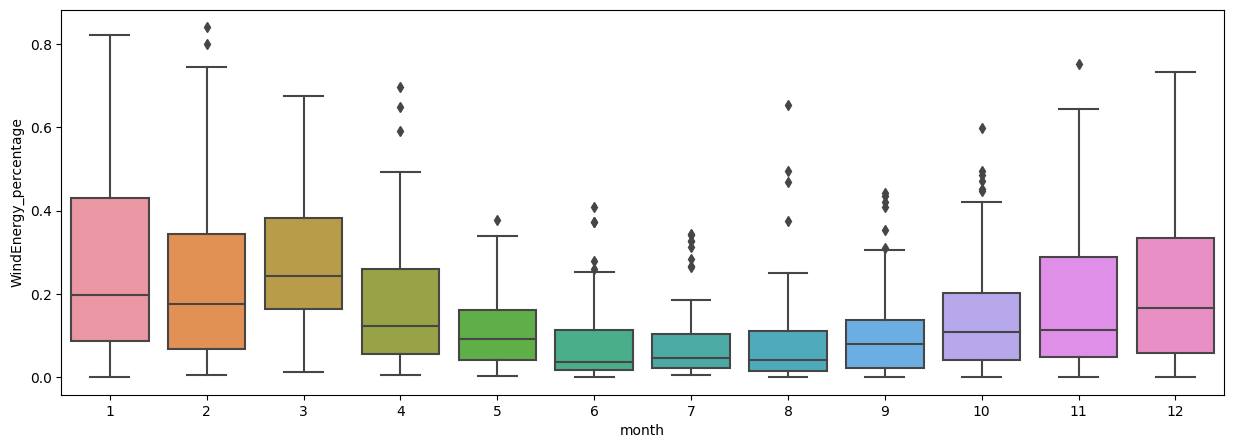

In [10]:
data['month'] = data.index.month
sns.boxplot(x='month',y='WindEnergy_percentage',data=data)

Se confirma la conclusión preliminar de que existe **estacionalidad** ya que **la potencia relativa generada es más alta en los primeros meses del año, despues decrece en los meses de primavera y verano, y vuelve a crecer a finales de año en otoño e invierno.**

Por otro lado, se ve que:

1. La **media no es constante** por la tendencia vista anteriormente
2. La **varianza tampoco es constante (heterocedasticidad).** Es más grande en los meses de mayor producción y más pequeña en los meses de menor producción.

## 3.2 Descomposición en tendencia-estacion-residuo

Para entender la dinámica que gobierna la serie, y para completar la conslusiones anteriores, se descompone la serie en:

- Tendencia
- Estacionalidad
- Residuos

Dada la dependencia del momento del año vista en la sección anterior, se propone hacer la descomposición en periodos de 12 meses (360 dias).

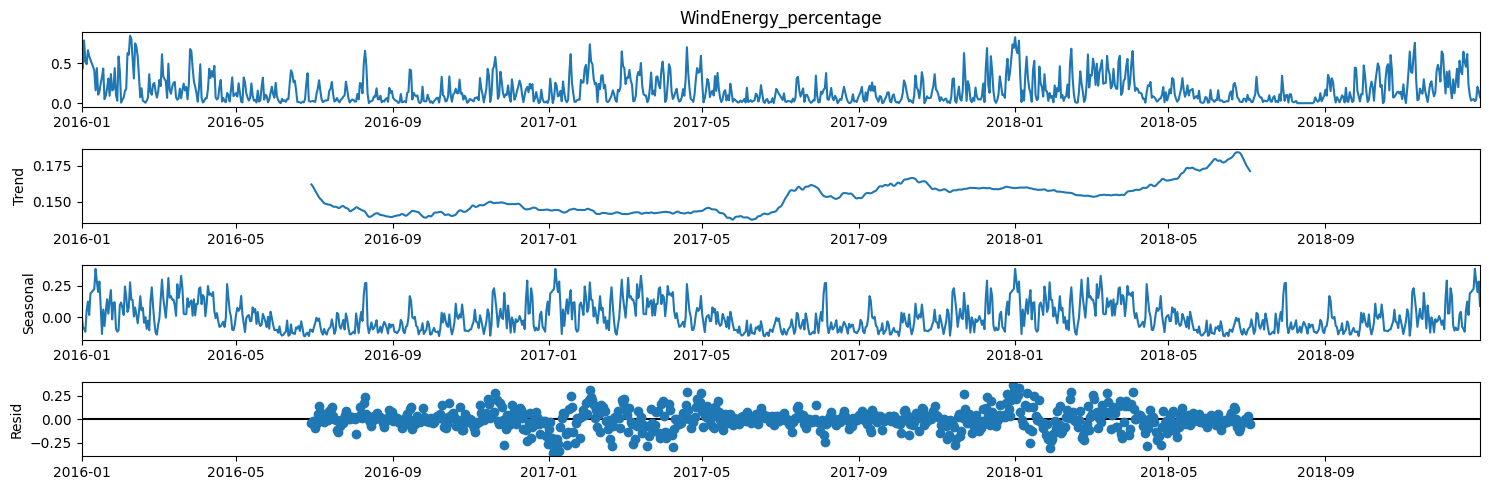

In [11]:
result = seasonal_decompose(data.WindEnergy_percentage, period=360)
result.plot();

Se observa que la tendencia sigue un patrón lineal escalonado, ya que se ven dos saltos de nivel bruscos en 2017-09 y 2018-09 respecto al año anterior. Se asume que existe tendencia creciente.

# 3.3 Análisis de autocorrelación y autocorrelación parcial

Se hace un gráfico de las funciones de autocorrelacion (ACF) y autocorrelación parcial (PACF) para detectar si la serie contiene información útil para pronosticar valores futuros. 

/home/daniel/anaconda3/envs/Amazon_Products_Reviews/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


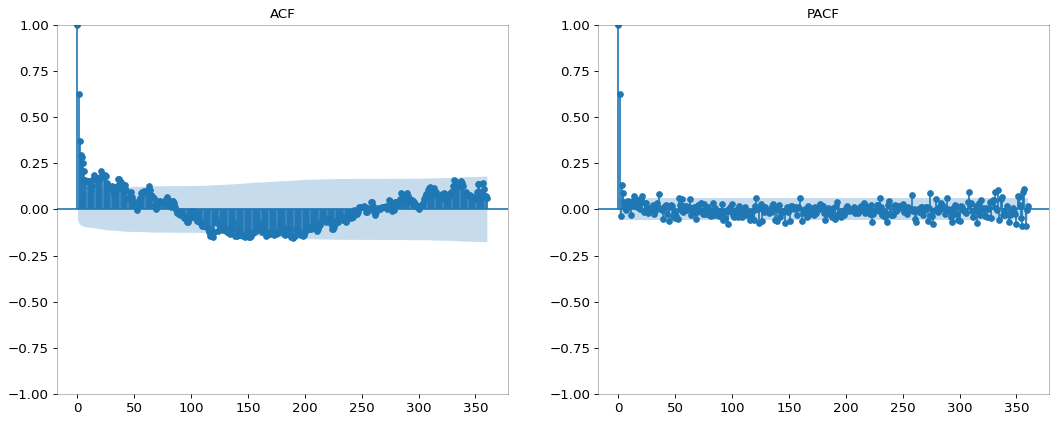

In [12]:
plot_acf_pacf_functions(data.WindEnergy_percentage, lags=360)

En la función ACF se ve autocorrlección significativa, a lo sumo, entre el el instante $t$ y $t+1, t+2$. Después, los valores de los coeficientes estan bajo de umbral de significación. Se ve la estacionalidad mencionada en las primeras secciones ya que se invierte el signo de la autocorrelación pese a que no es significativa.

La función PACF muestra que existe correlación significativa entre el instante $t$ y $t+1$, sin embargo, al desafectar el instante $t+2$ del $t+1$, la autocorrelación no es significativa. 

Segun la metodología Box-Jenkins se cumple que la función ACF sigue una onda sinusoidal y la función PACF decrece rápidamente a 0, por lo que la estrategia de modelización mas adecuada es un modelo AR.

**Se concluye que para modelizar el proceso, solo se debe considerar a lo sumo un retraso en la serie.**

## 3.4 Estacionariedad mediante cointegración

En esta sección se intenta conseguir estacionariedad mediante integración de la serie. Se calcula el pvalor del test Dickey-Fuller aumentado para ver si existe evidencia estadística de estacionariedad.

In [36]:
p_I0 = adfuller(data.WindEnergy_percentage)[1]
p_I1 = adfuller(data.WindEnergy_percentage.diff(1).dropna())[1]

print(f'pvalor aumiendo I(0): {p_I0}')
print(f'pvalor aumiendo I(1): {p_I1}')

pvalor aumiendo I(0): 0.0008235295304592358
pvalor aumiendo I(1): 3.549316191776998e-24


Se ve que no se puede aceptar la no estacionariedad en ambos casos. Es decir, existe evidencia para coniderar ambas estacionarias. Cabe señalar que si se asume estacionalidad (en duda ya que no existe evidencia suficiente), la hipotesis de estacionariedad no es válida, asique se debe proceder con relativo cuidado al definir los modelos.

<AxesSubplot: xlabel='Date'>

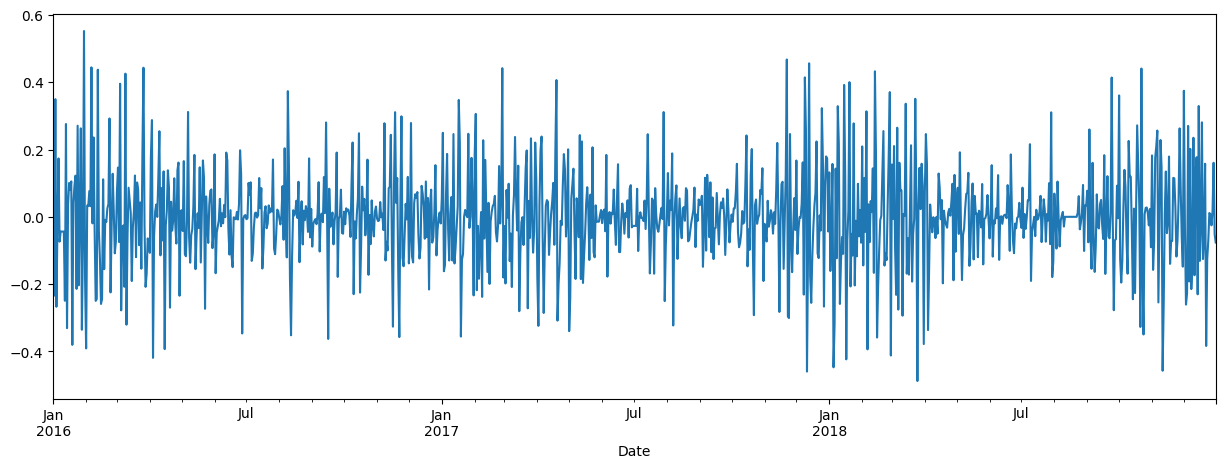

In [13]:
data.WindEnergy_percentage.diff(1).plot()

## 3.5 Conclusiones

Se observa que **la serie no tiene poder predictivo significativo sobre sí misma** mas allá de un periodo. Sin embargo, tampoco resulta significativo desde el punto de vista funcional (predicción energía eólica) una autocorrelación fuerte en días contiguos ya que un fenomeno climatológico puede persistir durante dos días, por ejemplo, desde las 10 PM hasta las 5 AM del día siguiente. Por lo que un mismo fenomeno puede aumentar la producción en dias contiguos y provocar esta autocorrelación.

Se observan además varios **hechos significativos**:

1. Estacionalidad anual. homogeneidad en la producción en un mismo mes.
2. No estacionariedad. El nivel de la serie varia dependiendo del mes.
3. Alto nivel de ruido que no puede explicarse a través de la propia serie.
4. Heterocedasticidad. La varianza varía segun del momento del año.

**Estos hechos sugieren que existen factores externos** que cumplen:

1. Repetición aproximadamente en la misma época del año
2. Aparición aleatoria dentro de un mismo periodo de tiempo a lo largo de los años
3. No se ven en la serie de producción de energía de manera explícita
4. Generan un shock a corto plazo que altera el comportamiento de la serie (varianza) en unos pocos lags y desaparecen

Por tanto, **para encontrar una estrategia de modelización adecuada se deben centrar los esfuerzos en**:

1. Encontrar **variables externas** que expliquen la variabilidad de la producción
2. **Considerar autocorrelaciones a largo plazo (anual) y muy corto plazo (a lo sumo un día o dos)**, desechando cualquier hipótesis de correlación en el medio plazo. 

# 4. Modelización

En esta sección se proponen varias metodologías para pronosticar la producción de energía eólica. Primera se hace la partición entre entrenamiento, test y validación. Despues de prueban varias aproximaciones típicas en el campo de estudio y se seleccionan los mejores modelos mediante validación cruzada.

Para evaluar cada modelo se utilizará como métrica el error cuadrático medio (MSE) sobre entrenamiento y testing. Una vez seleccionados los candidatos se compara el MSE en validación para decidir entre todos. 

## 4.1 Partición de entramiento, test y validación

Se realizan dos particiones:

1. Partición clásica. Se selecciona el año 2016 para entrenamiento, 2017 para test y 2018 para validación final.
2. Partición para emplear el método walk-forward: Se seleccionan 2016 y 2017 para entrenamiento y se deja 2018 a modo de validación.

### Partición clásica

In [18]:
y = data['WindEnergy_percentage']
X = data[['WindSpeed', 'WindDirection']]

In [19]:
data['year'] = data.index.year

In [20]:
X_train, X_test, X_validation = X[data.year.isin([2016])], X[data.year.isin([2017])], X[data.year.isin([2018])]
y_train, y_test, y_validation = y[data.year.isin([2016])], y[data.year.isin([2017])], y[data.year.isin([2018])]

### Partición de tipo walk-forward

Existen dos tipos de partición importantes:

- **Sliding window:** se coge un tamaño de ventana para train y para test y se corre la ventana hacia delante en el tiempo hasta agotar el conjunto de datos.
- **Expanding window:** se un tamaño de ventana inicial de train y un tamaño para test. En cada nueva iteración se añade el conjunto de test a train y se crea un nuevo conjunto de test del tamaño especificado hasta agotar el conjunto de datos.

Para el problema en cuestión, **es apropiado el método expanding window**, ya que es un modelo que se va a actualizar diariamente con cada nuevo dato y no requiere de olvidar datos pasados (Sliding Window no considera datos muy antiguos).

![validation](validation_windows.png)

Para plantear esta validación se hacen varias asunciones:

1. El modelo se utilizará para predecir la energía producida los próximos 7 días (horizonte de predicción de 7 periodos)
2. El modelo se actualizará cada día (en cada iteración se añade un periodo)
3. La venta de entrenamiento inicial es de un año (ventana inicial de 360 días).

In [41]:
splitter = ExpandingWindowSplitter(fh=list(range(1,8)), initial_window=360, step_length=1)
split_indexes = splitter.split(y)

Una vez definidos los indeices del split, basta ajustar iterativamente un modelo y guardar los scores seleccionados.

## 4.2 Ajuste del modelo ARX

Segun las conclusiones del análisis preliminar, la mejor estrategia consiste en definir un modelo autoregresivo que considere variables exógenas. De este modo se propone un modelo ARX de un unico lag y considerando las dos variables exogenas (velocidad y dirección del viento).

**Se asume que la dirección y velocidad del viento son variables que estaran disponibles a futuro, al menos, a modo de predicción meteorológica por lo que no son falsos predictores** y pueden usarse para resolver este problema.

In [43]:
ARX = SARIMAX(
    order=(1, 0, 0), trend=None)

y_train_pred = ARX.fit_predict(y_train, X_train, fh=X_train.index)  

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.19397D+00    |proj g|=  4.65962D+02

At iterate    5    f= -1.26136D+00    |proj g|=  3.10275D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     32      1     0     0   8.359D+00  -1.263D+00
  F =  -1.2626632902464727     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


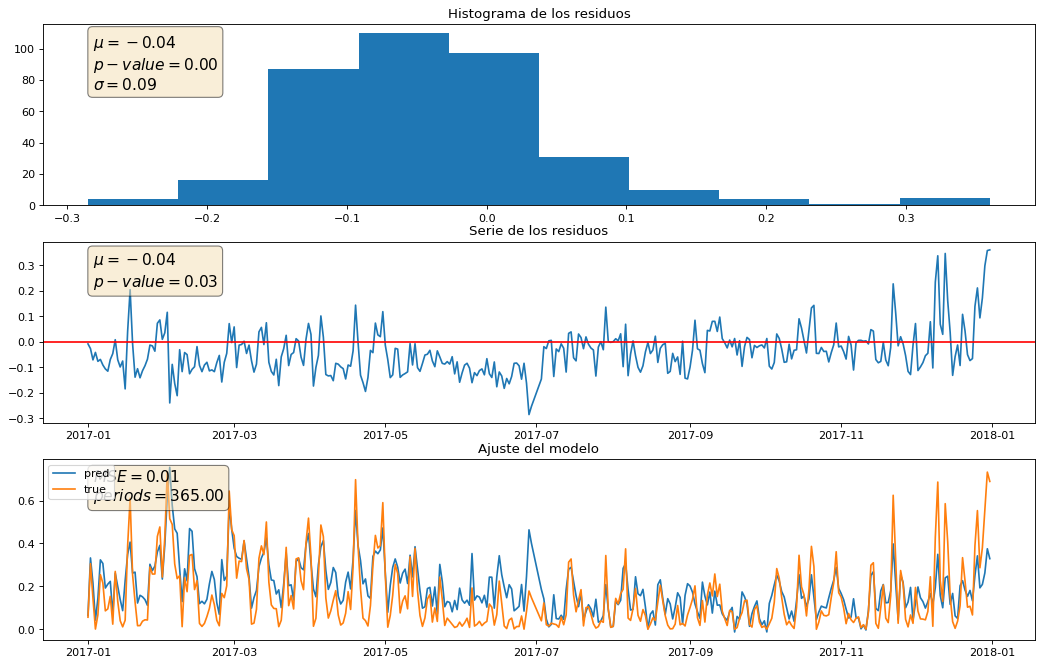

MSE: 0.009786293848089158


In [44]:
y_test_pred = ARX.predict(X=X_test, fh=X_test.index)
_ = ts_model_diagnostic(y_pred=y_test_pred, y_true=y_test)

Con la metodología propuesta se observan varios hechos significativos:
    
1. **Los residuos no son normales**, si bien tienen una propiedad deseable que es estar centrados en 0. La desviación respecto a la normalidad viene de una cola muy marcada hacia la derecha. Esto es porque se ha sobreestimado el verdadero valor de un conjunto de observaciones. 

2. **Los residuos son estacionarios** segun el test Dickey-Fuller y estan centrados en cero. Sin embargo, al no cumplir la hipótesis de normalidad **no se puede asumir que es ruido blanco**, por lo que el modelo no está correctamente especificado si se rechaza la normalidad. 

3. **En las predicciones se aprecia que los pronósticos suelen estar cercanos a la realidad** salvo los meses de mayo, Junio y Julio de 2017, donde se subestima el verdadero valor de producción y a finales de 2017 donde se sobreestima fuertemente el verdadero valor de producción.

Con estos hechos se puede concluir que la desviación respecto a la normal de los residuos viene de observaciones atípicas durante algunos meses de 2017. Puede aceptarse que el modelo está correctamente especificado, dada la complejidad de los datos que se estan tratando a falta de estudiar en detalle las observaciones que han causado la desviación. 

Una vez aceptada la correcta especificación, se calculan los estadísticos resumen del ajuste para verificar que el modelo está correctamente definido. 

In [45]:
ARX.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:     WindEnergy_percentage   No. Observations:                  366
Model:                  SARIMAX(1, 0, 0)   Log Likelihood                 462.135
Date:                   Sat, 10 Dec 2022   AIC                           -916.270
Time:                           14:50:07   BIC                           -900.659
Sample:                       01-01-2016   HQIC                          -910.066
                            - 12-31-2016                                         
Covariance Type:                     opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
WindSpeed         0.0435      0.001     39.217      0.000       0.041       0.046
WindDirection    -0.0004   3.87e-05     -9.714      0.000      -0.000      -0.000
ar.L1             0.6366      0.040     16.034      0.000       0.559       0.714
sigma2            0.0047      0.000     11.270      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   3.46   Jarque-Bera (JB):                64.76
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             0.80
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Se observa que los p-valores de los test de la t de Student sobre los coeficientes son 0. Ninguno de los intervalos de confianza de los parámetros contiene el 0, por lo que todos los parámetros son significativos (no se debe eliminar ninguna de las variables intorucidas en el modelo).

## 4.3 Ajuste de modelos no específicos para series temporales

En esta sección se ajustan varios modelos que no son especificos para series temporales (no utilizan información de otros instantes de manera explícita) pero que en general dan buenos resultados segun la experiencia en este problema. En particular se utilizan SVMs y un tipo especial de red neuronal (LSTM).

### 4.3.1 SVM

Se emplea un modelo SVM con kernel lineal, ya que no existe evidencia de que el problema requiera un kernel polinomico o gausssiano. se crea la variable y_lag1 para introducir información pasada.

In [46]:
X_SVR = X.copy()
X_SVR['y_lag1'] = y.shift(1)
X_SVR = X_SVR.dropna()
y_SVR = y[1:].copy()

X_SVR_train, X_SVR_test, X_SVR_validation = X_SVR[data.year.isin([2016])], X_SVR[data.year.isin([2017])], X_SVR[data.year.isin([2018])]
y_SVR_train, y_SVR_test, y_SVR_validation = y_SVR[data.year.isin([2016])], y_SVR[data.year.isin([2017])], y_SVR[data.year.isin([2018])]

/tmp/ipykernel_8943/3366165296.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_SVR_train, X_SVR_test, X_SVR_validation = X_SVR[data.year.isin([2016])], X_SVR[data.year.isin([2017])], X_SVR[data.year.isin([2018])]


Se escalan los datos para favorecer el proceso de optimización. Se crea una pipeline de sklearn que contiene todo el proceso.

In [47]:
SVM_pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVR(kernel='linear', C=100))])
SVM_pipeline.fit(X_SVR_train, y_SVR_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', SVR(C=100, kernel='linear'))])

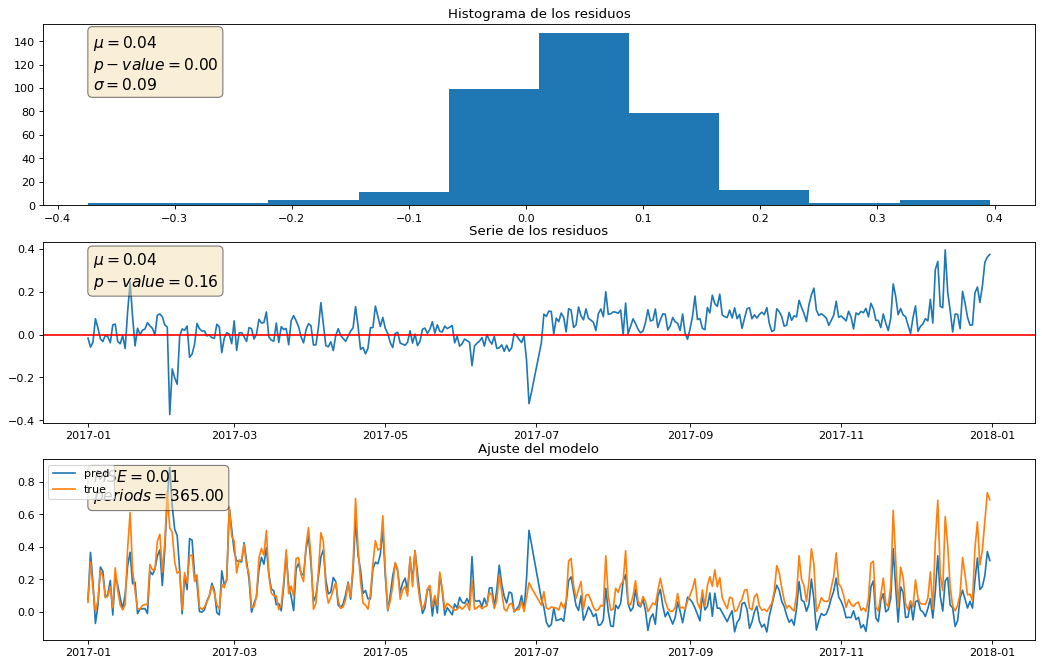

MSE: 0.009714768128843346


In [48]:
y_pred_test_SVR = pd.Series(SVM_pipeline.predict(X_SVR_test), index=X_SVR_test.index)
_ = ts_model_diagnostic(y_pred=y_pred_test_SVR, y_true=y_SVR_test)

Se obtienen unos resultaods muy similares al modelo ARX, sin embargo, los residuos ahora no son estacionarios. Por lo que el modelo no está correctamente especificado. Con esta metodología no se obtiene un modelo válido. Se observa que nuevamente hay problemas para estimar a finales del año 2017, ya que se sobreestima fuertemente el valor de la producción.

### 4.3.2 Redes neuronales (LSTM)

Se crea una red neuronal con una capa LSTM para tener en cuenta información pasada. Se utilizará como input la información de 7 días para predecir la producción del día inmediatamente posterior a esa semana.

In [21]:
n_past, n_future = 7, 1

def create_rnn():
    set_random_seed(123)

    rnn = Sequential()
    rnn.add(LSTM(50, input_shape=(n_past, 3)))
    rnn.add(Dropout(0.5, input_shape=(1,)))
    rnn.add(Dense(1))
    rnn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
    return rnn

In [22]:
RNN = create_rnn()

2022-12-11 19:22:58.401585: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-11 19:22:58.404153: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-11 19:22:58.404336: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (daniel): /proc/driver/nvidia/version does not exist
2022-12-11 19:22:58.409184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10800     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________


Se crean los conjuntos de entrenamiento, test y validacion como en las secciones anteriores. Se escalan los valores con el criterio minmax. 

In [34]:
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit(data).transform(data), columns=data.columns, index=data.index)

y_LSTM = data_scaled['WindEnergy_percentage'].copy()
X_LSTM = data_scaled[['WindSpeed', 'WindDirection']].copy()

X_LSTM['y_lag1'] = y_LSTM.shift(1)
X_LSTM = X_LSTM.dropna()
y_LSTM = y_LSTM[1:].copy()

X_LSTM_train, X_LSTM_test, X_LSTM_validation = X_LSTM[X_LSTM.index.year.isin([2016])], X_LSTM[X_LSTM.index.year.isin([2017])], X_LSTM[X_LSTM.index.year.isin([2018])]
y_LSTM_train, y_LSTM_test, y_LSTM_validation = y_LSTM[y_LSTM.index.year.isin([2016])], y_LSTM[y_LSTM.index.year.isin([2017])], y_LSTM[y_LSTM.index.year.isin([2018])]

In [35]:
X_LSTM_train[:7]

,WindSpeed,WindDirection,y_lag1
Date,,,
2016-01-02,0.505469,0.604457,0.791250
2016-01-03,0.851468,0.621170,0.513147
2016-01-04,0.544041,0.696379,0.929037
2016-01-05,0.622913,0.727019,0.611068
2016-01-06,0.732297,0.618384,0.577661
2016-01-07,0.813472,0.649025,0.784187
2016-01-08,0.763241,0.655292,0.696507


In [36]:
len(X_LSTM_train)

365

Se adapta el formato a la red neuronal. Se crean observaciones de 7 días con las 3 variables, por tanto, cada observacion será una matriz 7 x 3. Se pierden algunas observaciones ya que se estan agrupando observaciones para crear el input. Al inicio se tienen 365 observaciones y tras la transformación se tienen 358.

Para crear la variable target, se eliminan las otras variables tras el split. 

In [37]:
X_LSTM_train, y_LSTM_train  = split_series(X_LSTM_train.to_numpy(), n_past=n_past, n_future=1)
y_LSTM_train = y_LSTM_train[:, 0, 2].reshape(len(y_LSTM_train), 1, 1)

X_LSTM_test, y_LSTM_test = split_series(X_LSTM_test.to_numpy(), n_past=n_past, n_future=1)
y_LSTM_test = y_LSTM_test[:, 0, 2].reshape(len(y_LSTM_test), 1, 1)

X_LSTM_validation, y_LSTM_validation  = split_series(X_LSTM_validation.to_numpy(), n_past=n_past, n_future=1)
y_LSTM_validation = y_LSTM_validation[:, 0, 2].reshape(len(y_LSTM_validation), 1, 1)

In [38]:
X_LSTM_train[0]

array([[0.5054692 , 0.60445682, 0.79124982],
       [0.85146805, 0.62116992, 0.51314735],
       [0.54404145, 0.69637883, 0.92903651],
       [0.62291307, 0.7270195 , 0.61106789],
       [0.73229706, 0.6183844 , 0.57766081],
       [0.8134715 , 0.64902507, 0.78418686],
       [0.76324122, 0.65529248, 0.6965071 ]])

In [144]:
len(X_LSTM_train)

358

Se entrena la red con 1000 epocas. **Dado que se ha incluido una capa Dropout no se espera overfitting en el problema.** Esta capa de Dropout, hace 0 el input de alguna neurona aleatoriamente. Esto fuerza a que todas las neuronas se comuniquen entre sí y que las neuronas no solo optimicen los pesos de alguna de las unidades de la capa anterior. Se fija la proporción de neuronas a anular en 0.5 como es usual en la literatura. 

![dropout](dropout.png)

In [145]:
RNN.fit(X_LSTM_train, y_LSTM_train, epochs=1000, validation_data=(X_LSTM_test,y_LSTM_test))

Epoch 1/1000
12/12 [==============================] - 2s 37ms/step - loss: 0.0388 - mean_squared_error: 0.0388 - val_loss: 0.0294 - val_mean_squared_error: 0.0294
Epoch 2/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0360 - mean_squared_error: 0.0360 - val_loss: 0.0292 - val_mean_squared_error: 0.0292
Epoch 3/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0270 - val_mean_squared_error: 0.0270
Epoch 4/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0264 - val_mean_squared_error: 0.0264
Epoch 5/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0278 - mean_squared_error: 0.0278 - val_loss: 0.0264 - val_mean_squared_error: 0.0264
Epoch 6/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0281 - mean_squared_error: 0.0281 - val_loss: 0.0246 - val_mean_squared_error: 0.0246
Epoch 7/1000
12/12 [======

12/12 [==============================] - 0s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 102/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 103/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 104/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 105/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 106/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0094 - val_mean_squared_error: 0.0094
Epoch 107/1000
12/12 [=========

Epoch 151/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 152/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 153/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 154/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 155/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 156/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 157/1000
1

Epoch 201/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 202/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 203/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 204/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 205/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 206/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 207/10

Epoch 251/1000
12/12 [==============================] - 0s 13ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 252/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 253/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 254/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 255/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 256/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 257/

Epoch 301/1000
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 302/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 303/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 304/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 305/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 306/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 307/

Epoch 351/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 352/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 353/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 354/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 355/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 356/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 357/1

Epoch 401/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 402/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 403/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 404/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 405/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 406/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 407/1000


Epoch 451/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 452/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 453/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 454/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 455/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 456/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 457/100

Epoch 501/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 502/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 503/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 504/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 505/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 506/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 507/100

Epoch 551/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 552/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 553/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 554/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 555/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 556/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 557/10

Epoch 601/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 602/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 603/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 604/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 605/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 606/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 607/1

Epoch 651/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 652/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 653/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 654/1000
12/12 [==============================] - 0s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 655/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 656/1000
12/12 [==============================] - 0s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 657/100

Epoch 701/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 702/1000
12/12 [==============================] - 0s 13ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 703/1000
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 704/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 705/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 706/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 707/

Epoch 751/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 752/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 753/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 754/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 755/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 756/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 757/

Epoch 801/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 802/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 803/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 804/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 805/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 806/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 807/1000

Epoch 851/1000
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 852/1000
12/12 [==============================] - 0s 16ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 853/1000
12/12 [==============================] - 0s 15ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 854/1000
12/12 [==============================] - 0s 14ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 855/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 856/1000
12/12 [==============================] - 0s 14ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 857/

Epoch 901/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 902/1000
12/12 [==============================] - 0s 14ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 903/1000
12/12 [==============================] - 0s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 904/1000
12/12 [==============================] - 0s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 905/1000
12/12 [==============================] - 0s 15ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 906/1000
12/12 [==============================] - 0s 15ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 907/

Epoch 951/1000
12/12 [==============================] - 0s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 952/1000
12/12 [==============================] - 0s 14ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 953/1000
12/12 [==============================] - 0s 15ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 954/1000
12/12 [==============================] - 0s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 955/1000
12/12 [==============================] - 0s 14ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 956/1000
12/12 [==============================] - 0s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 957/

In [147]:
y_pred_LSTM_test = pd.Series(RNN.predict(X_LSTM_test).flatten())
y_LSTM_test = pd.Series(y_LSTM_test.flatten())

12/12 [==============================] - 0s 2ms/step


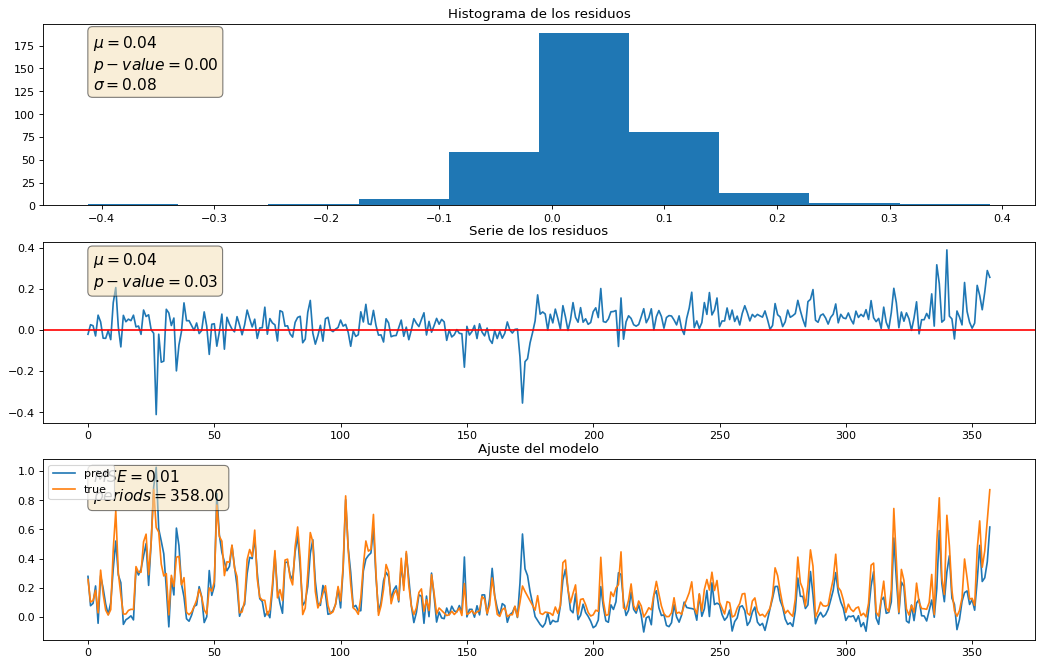

MSE: 0.007345257515814236


0.007345257515814236

In [148]:
ts_model_diagnostic(y_true=y_LSTM_test, y_pred=y_pred_LSTM_test)

## 4.4 Comparación de resultados

### 4.4.1 Resultado en validacion de LSTMs

12/12 [==============================] - 0s 3ms/step


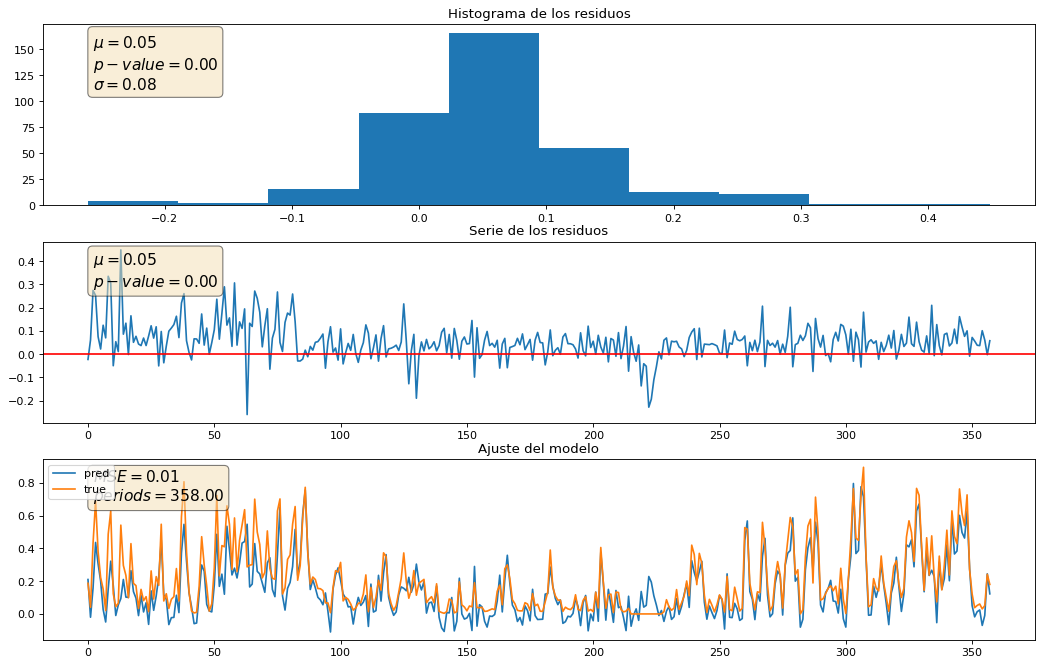

MSE: 0.009259724337940107


In [164]:
y_pred_LSTM_validation= pd.Series(RNN.predict(X_LSTM_validation).flatten())
y_LSTM_validation = pd.Series(y_LSTM_validation.flatten())

_ = ts_model_diagnostic(y_true=y_LSTM_validation, y_pred=y_pred_LSTM_validation)

### 4.4.2 Resultado en validacion de SVMs

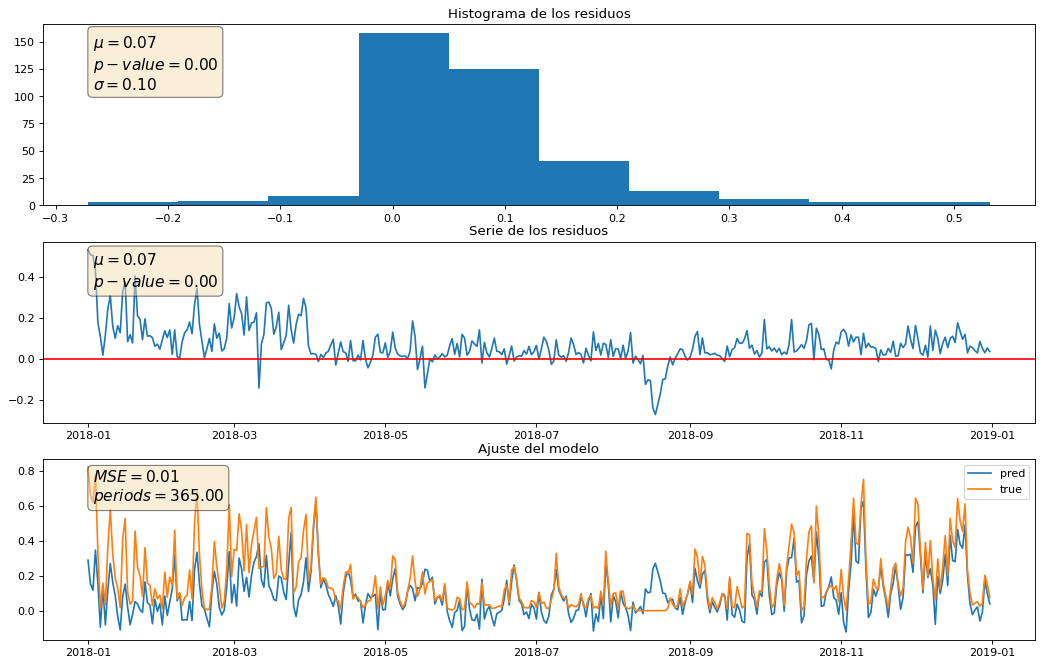

MSE: 0.014241186787297286


In [152]:
y_pred_validation_SVR = pd.Series(SVM_pipeline.predict(X_SVR_validation), index=X_SVR_validation.index)

_ = ts_model_diagnostic(y_pred=y_pred_validation_SVR, y_true=y_SVR_validation)

## 4.5 Conclusiones

En vista de los resultados de validacion se ven varios hechos significativos:

1. **No se ha logrado un modelo correctamente especificado ni en ARX, ni SVMs ni LSTM.** Los residuos muestran una cola marcada hacia la derecha (sobreestimación del verdadero valor de producción) en todos los casos. Aunque no es una desviación significativa, es suficiente para desviar la distribución de los residuos de la normalidad. **Esto es signo de que existen mas variables ocultas a considerar para resolver el problema, ya que hay evidencia de que esas observaciones se han generado mediante una distribución distinta al resto.**


2. **El mejor modelo es la red neuronal LSTM** (sin refinar los hiperparametros ni la topología de la red). Muestra un error cuadratico medio muy inferior a SVMs y ARX tanto en train, test y validacion.

| Modelo | Fase | MSE  |
| :- | -: | -: |
| LSTM | Train | 0.0019 |
| SVM | Train | 0.0025|
| ARX | Train | 0.0047 |
| LSTM | Test | 0.0073|
| SVM | Test | 0.0097|
| ARX | Test | 0.0097 |
| LSTM | Validacion | 0.0092|
| SVM | Validacion | 0.0142|


Se debe comprobar la degradación de los modelos mediante un entrenamiento walk-forward. Por tiempo y extensión de la practica se deja aquí el ejercicio. 